# Porto Seguro’s Safe Driver Prediction

Porto Seguro is one of Brazil’s largest auto and homeowner insurance companies. For this case study, they have provided a dataset for auto insurance using which we need to predict the probability whether a customer that has bought auto insurance will initiate an auto insurance claim in the next year. 

Solving the given problem statement is useful because if we could predict whether the customer will initiate an auto insurance claim in the next year, the insurance provider can charge a higher premium to that particular customer as the chance of the customer claiming insurance is very high. On the other hand, if we could predict if a customer will most likely not initiate an auto insurance claim in the next year, the insurance provider can charge a lower premium to that customer. This is particularly useful now-a-days as customers can apply for auto insurance through the internet and get quotes from multiple insurance providers and will choose the provider who quoted the lowest premium with the same benefits as others.

More information can be found here: https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/overview

## Evaluation Metric

The evaluation metric used for this problem is Normalized Gini Coefficient.

During scoring, observations are sorted from the largest to the smallest predictions. Predictions are only used for ordering observations; therefore, the relative magnitude of the predictions are not used during scoring. The scoring algorithm then compares the cumulative proportion of positive class observations to a theoretical uniform proportion.

The Gini Coefficient ranges from approximately 0 for random guessing, to approximately 0.5 for a perfect score. <Br>
The Normalized Gini Coefficient adjusts the score by the theoretical maximum so that the maximum score is 1.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\vigne\anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading Data

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
print(len(train_df))

595212


There are 5,95,212 data points in our train dataset

## Basic EDA of dataset

In [4]:
print('The column names in our dataset are:')
for col_name in train_df.columns:
    print(col_name)

The column names in our dataset are:
id
target
ps_ind_01
ps_ind_02_cat
ps_ind_03
ps_ind_04_cat
ps_ind_05_cat
ps_ind_06_bin
ps_ind_07_bin
ps_ind_08_bin
ps_ind_09_bin
ps_ind_10_bin
ps_ind_11_bin
ps_ind_12_bin
ps_ind_13_bin
ps_ind_14
ps_ind_15
ps_ind_16_bin
ps_ind_17_bin
ps_ind_18_bin
ps_reg_01
ps_reg_02
ps_reg_03
ps_car_01_cat
ps_car_02_cat
ps_car_03_cat
ps_car_04_cat
ps_car_05_cat
ps_car_06_cat
ps_car_07_cat
ps_car_08_cat
ps_car_09_cat
ps_car_10_cat
ps_car_11_cat
ps_car_11
ps_car_12
ps_car_13
ps_car_14
ps_car_15
ps_calc_01
ps_calc_02
ps_calc_03
ps_calc_04
ps_calc_05
ps_calc_06
ps_calc_07
ps_calc_08
ps_calc_09
ps_calc_10
ps_calc_11
ps_calc_12
ps_calc_13
ps_calc_14
ps_calc_15_bin
ps_calc_16_bin
ps_calc_17_bin
ps_calc_18_bin
ps_calc_19_bin
ps_calc_20_bin


The feature names that end with 'bin' means that they are binary features. <Br>
The feature names that end with 'cat' means that they are categorical features. <Br>
Feature names without these designations are either continuous or ordinal

In [5]:
print('Number of input features: ',len(train_df.columns)-2)  # Removing the target variable that we need to predict
                                                             # and id variable which is the identifier for each data point

Number of input features:  57


In [6]:
print('Columns that contain null values:')
print(train_df.isnull().any()[lambda x:x])  # Checking for Null (NaN) values

Columns that contain null values:
Series([], dtype: bool)


There are no null values in our dataset. So, all the columns in our dataset have proper values. <br>
But as per Porto Seguro who provided the dataset, if a feature was missing from observation, it is denoted using the value '-1'

In [7]:
print('Columns that contain missing values (value = -1):')
print(train_df[train_df==-1].any()[lambda x:x])

Columns that contain missing values (value = -1):
ps_ind_02_cat    True
ps_ind_04_cat    True
ps_ind_05_cat    True
ps_reg_03        True
ps_car_01_cat    True
ps_car_02_cat    True
ps_car_03_cat    True
ps_car_05_cat    True
ps_car_07_cat    True
ps_car_09_cat    True
ps_car_11        True
ps_car_12        True
ps_car_14        True
dtype: bool


In [8]:
print('Number of missing values in each column:')
print((train_df[train_df==-1].sum()[lambda x:x!=0]) * -1)

Number of missing values in each column:
ps_ind_02_cat       216.0
ps_ind_04_cat        83.0
ps_ind_05_cat      5809.0
ps_reg_03        107772.0
ps_car_01_cat       107.0
ps_car_02_cat         5.0
ps_car_03_cat    411231.0
ps_car_05_cat    266551.0
ps_car_07_cat     11489.0
ps_car_09_cat       569.0
ps_car_11             5.0
ps_car_12             1.0
ps_car_14         42620.0
dtype: float64


The above features all have missing values with ps_car_03_cat feature having highest number of missing values (411,231). <Br>
We can try imputing some other values for these missing values.

### EDA of Target variable:

Text(0, 0.5, 'Count')

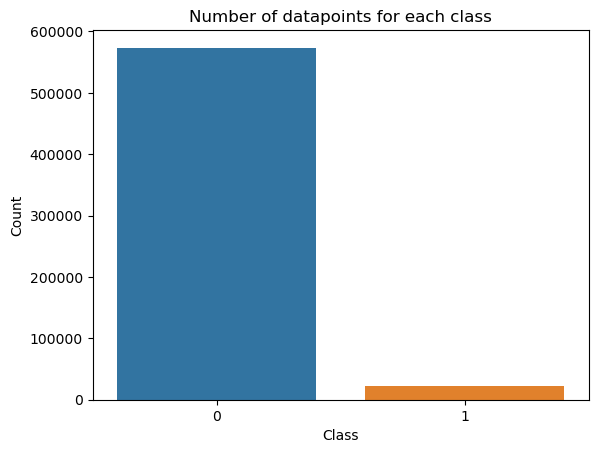

In [9]:
plt.title('Number of datapoints for each class')
sns.barplot(x= train_df['target'].unique(), y = train_df['target'].value_counts());
plt.xlabel('Class')
plt.ylabel('Count')

In [10]:
target_value_counts = train_df['target'].value_counts()
percentage_no_claim = np.round(target_value_counts[0]/len(train_df),4) * 100
percentage_claim = np.round(target_value_counts[1]/len(train_df),4) * 100
print('There are {a:,} ({b}%) cases where the customer has not filed any claim and \
{c:,} ({d}%) cases where the customer has \nfiled for insurance claim in our dataset'.format(a = target_value_counts[0],
                                                                                              b = percentage_no_claim,
                                                                                              c = target_value_counts[1],
                                                                                              d = percentage_claim))

There are 573,518 (96.36%) cases where the customer has not filed any claim and 21,694 (3.64%) cases where the customer has 
filed for insurance claim in our dataset


This is a highly imbalanced dataset.

## EDA Of Binary Features

In [11]:
bin_features = [col for col in train_df.columns if "bin" in str(col)]
train_df_bin = train_df[bin_features]    # Getting all columns with column names that contain the string "bin"

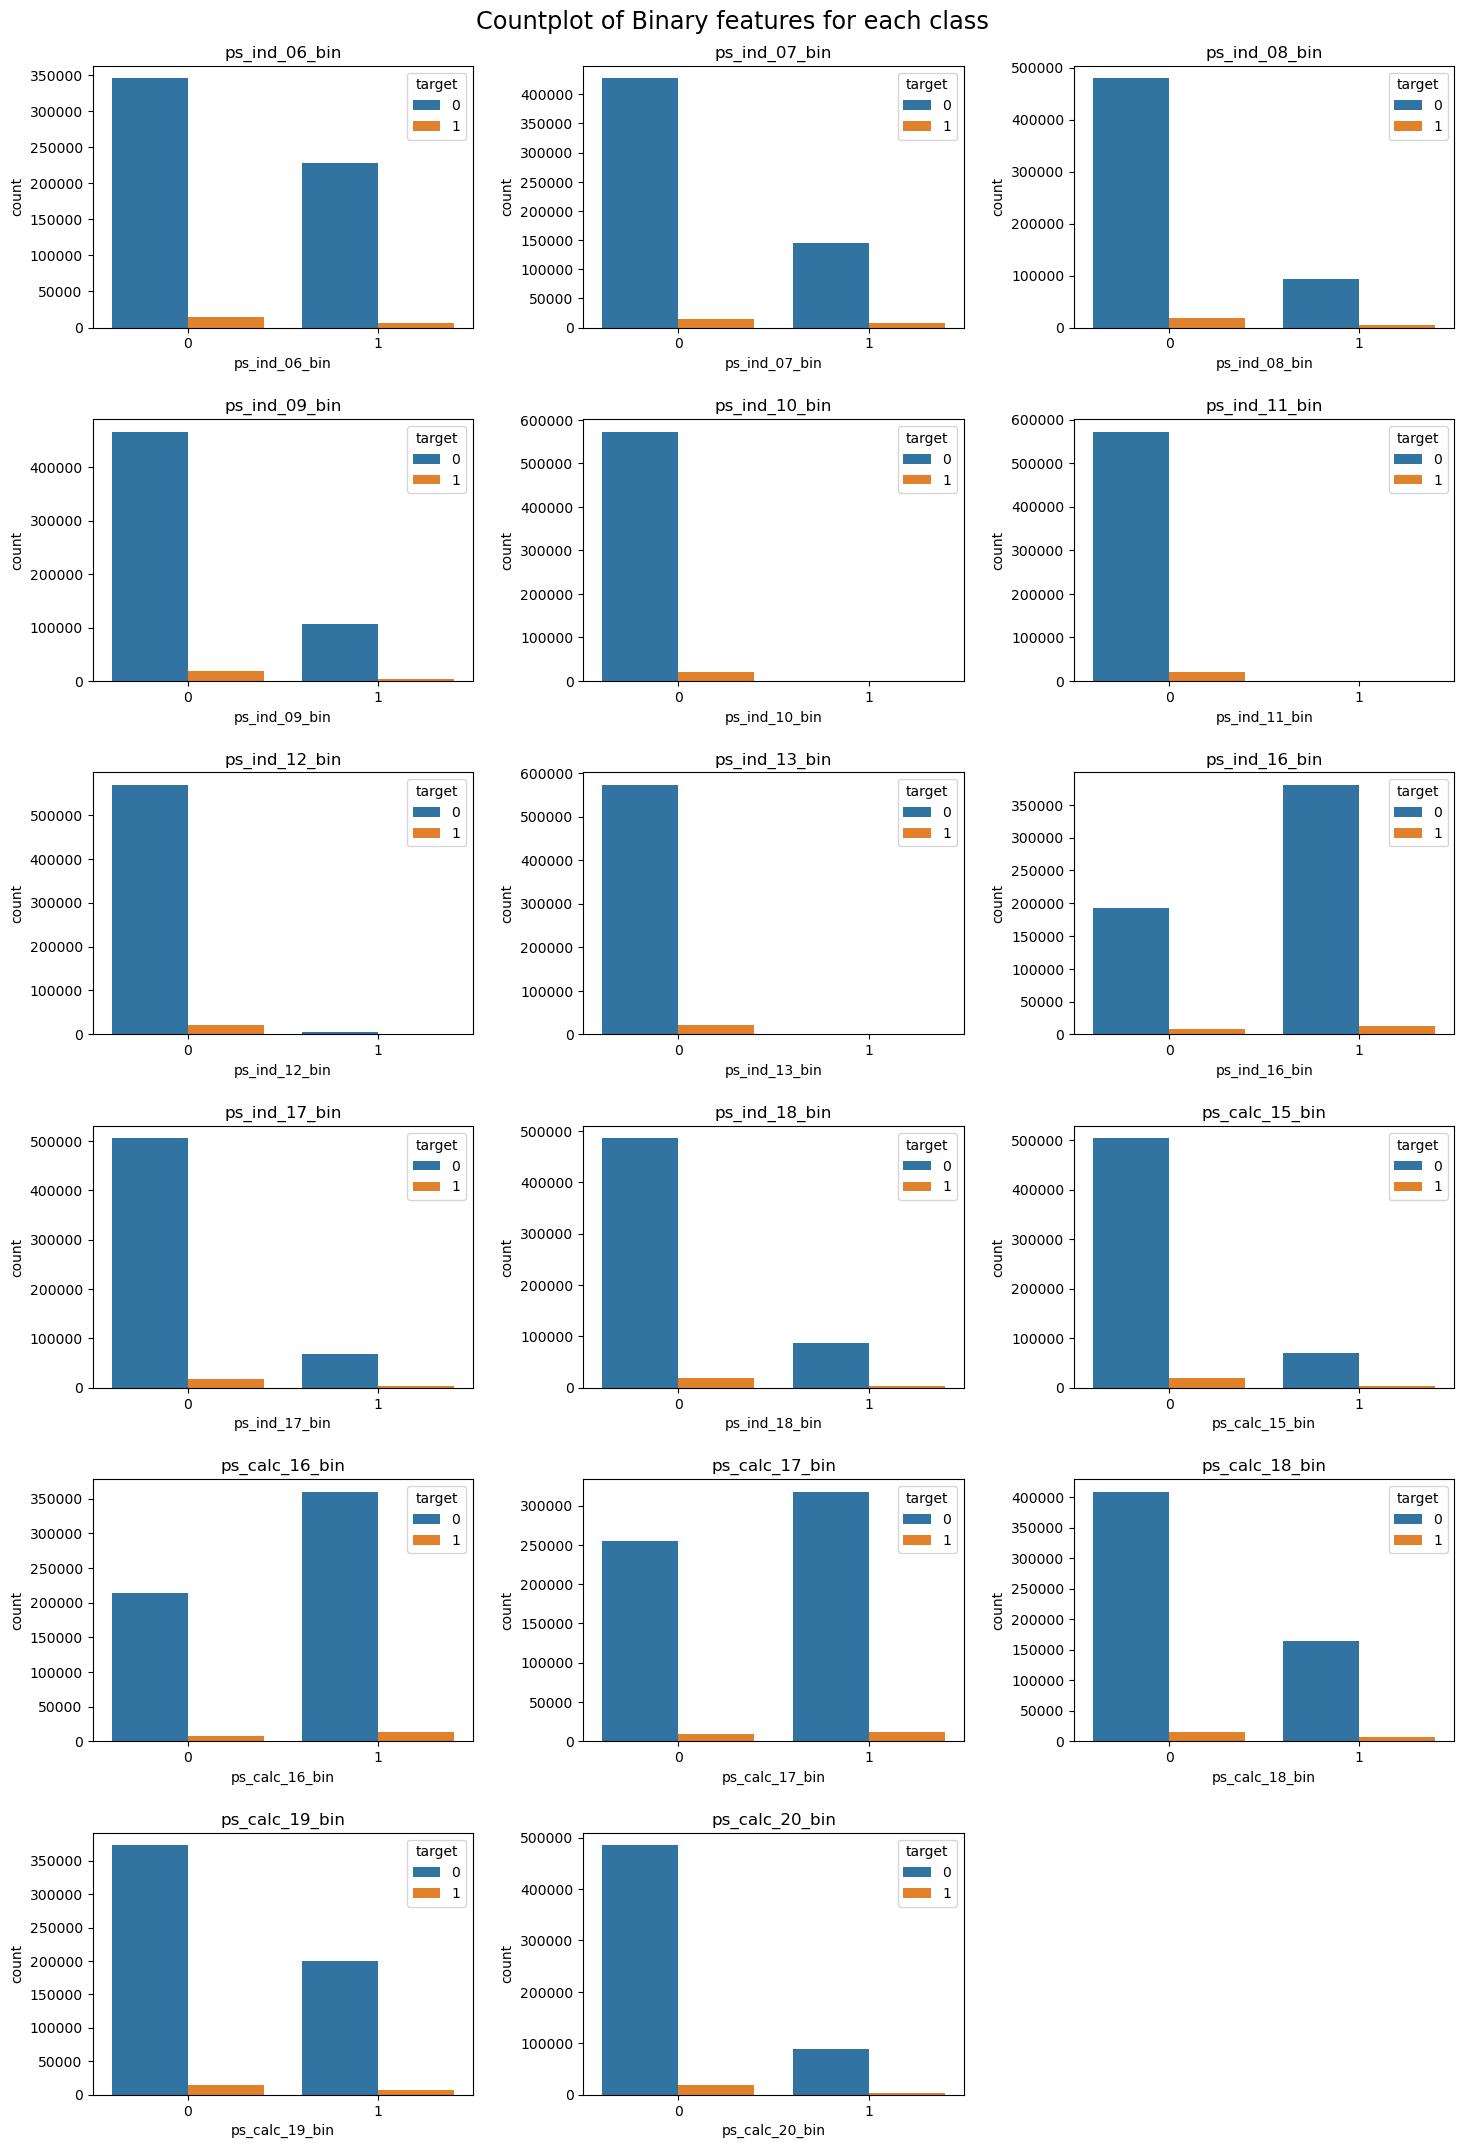

In [12]:
# Plotting count of 0 and 1 values for binary features and using different colors for target 0 and 1
plt.figure(figsize = (15,22))
for i in range(len(bin_features)):
    plt.subplot(6,3,i+1)
    plt.suptitle('Countplot of Binary features for each class', fontsize = 'xx-large')
    plt.title(bin_features[i])
    sns.countplot(x = train_df_bin[bin_features[i]], hue = train_df['target'])  
    plt.tight_layout(pad= 2)    # tight_layout gives good spacing between each subplot 
                                # pad parameter increases the spacing between subplots

In [13]:
low_number_of_1 = ['ps_ind_10_bin','ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin']
print("Number of datapoints that have value '1' for feature:")
for i in low_number_of_1:
    print(i,' - ', train_df_bin[i].value_counts()[1])

Number of datapoints that have value '1' for feature:
ps_ind_10_bin  -  222
ps_ind_11_bin  -  1007
ps_ind_12_bin  -  5618
ps_ind_13_bin  -  564


## Observations:
1. Features ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin have the same value (0) for nearly all the datapoints.
2. None of the binary features have a clear relationship in determining if insurance will be claimed or not.

## EDA of categorical Features

In [14]:
cat_features = [col for col in train_df.columns if "cat" in str(col)]
train_df_cat = train_df[cat_features]    # Getting all columns with column names that contain the string "cat"

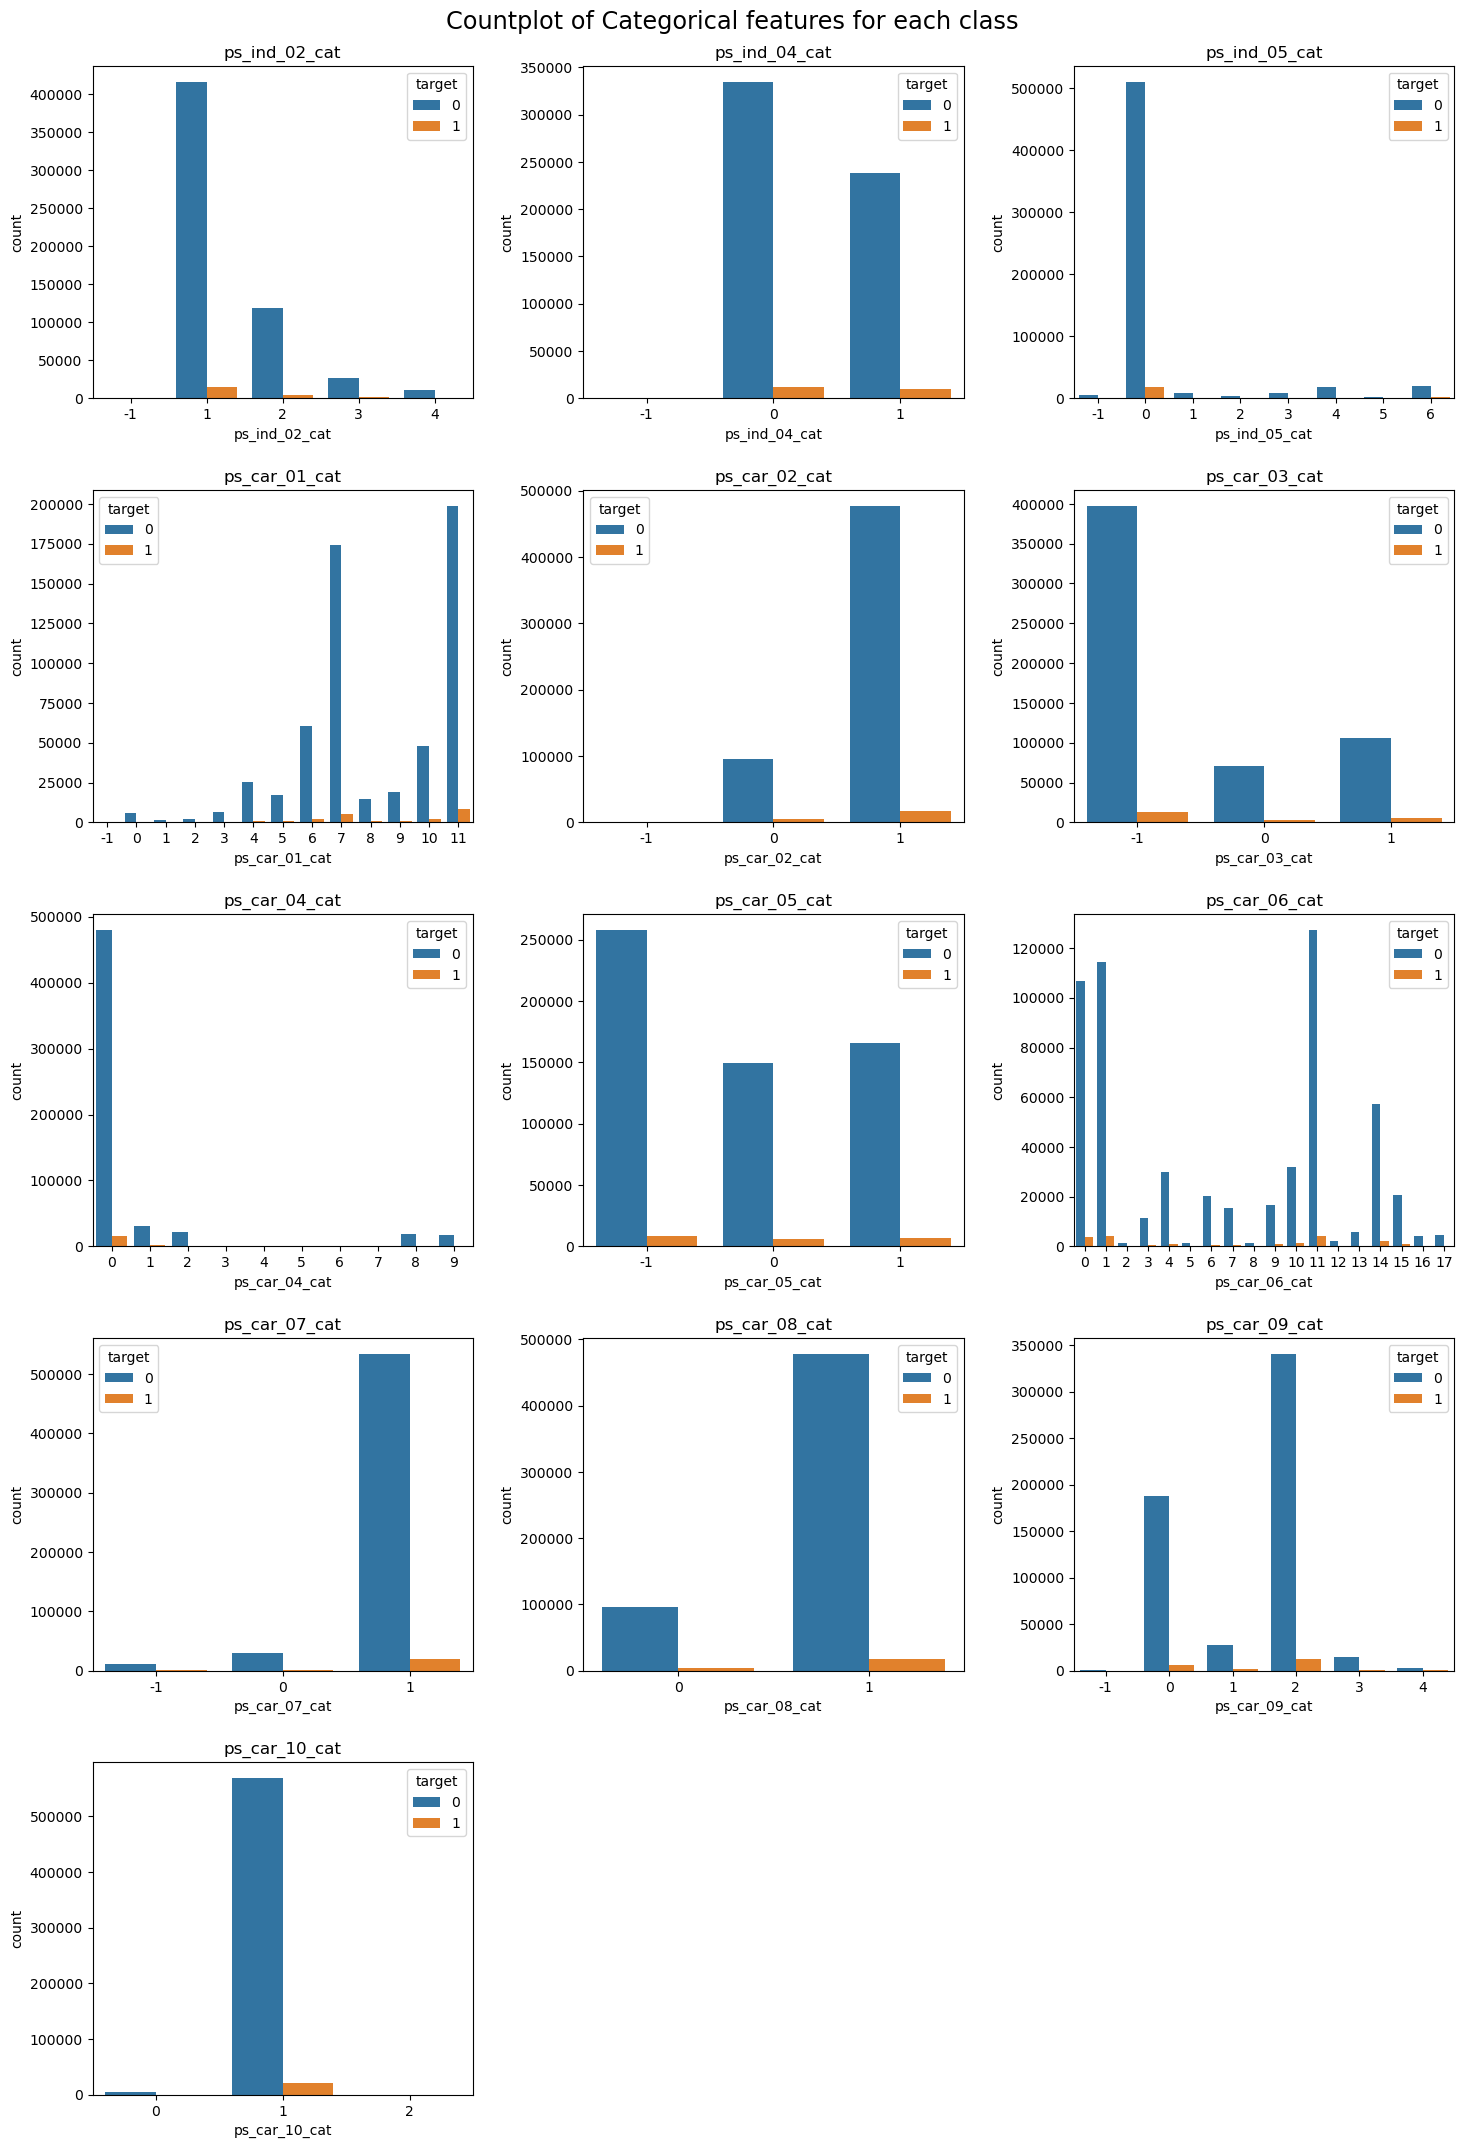

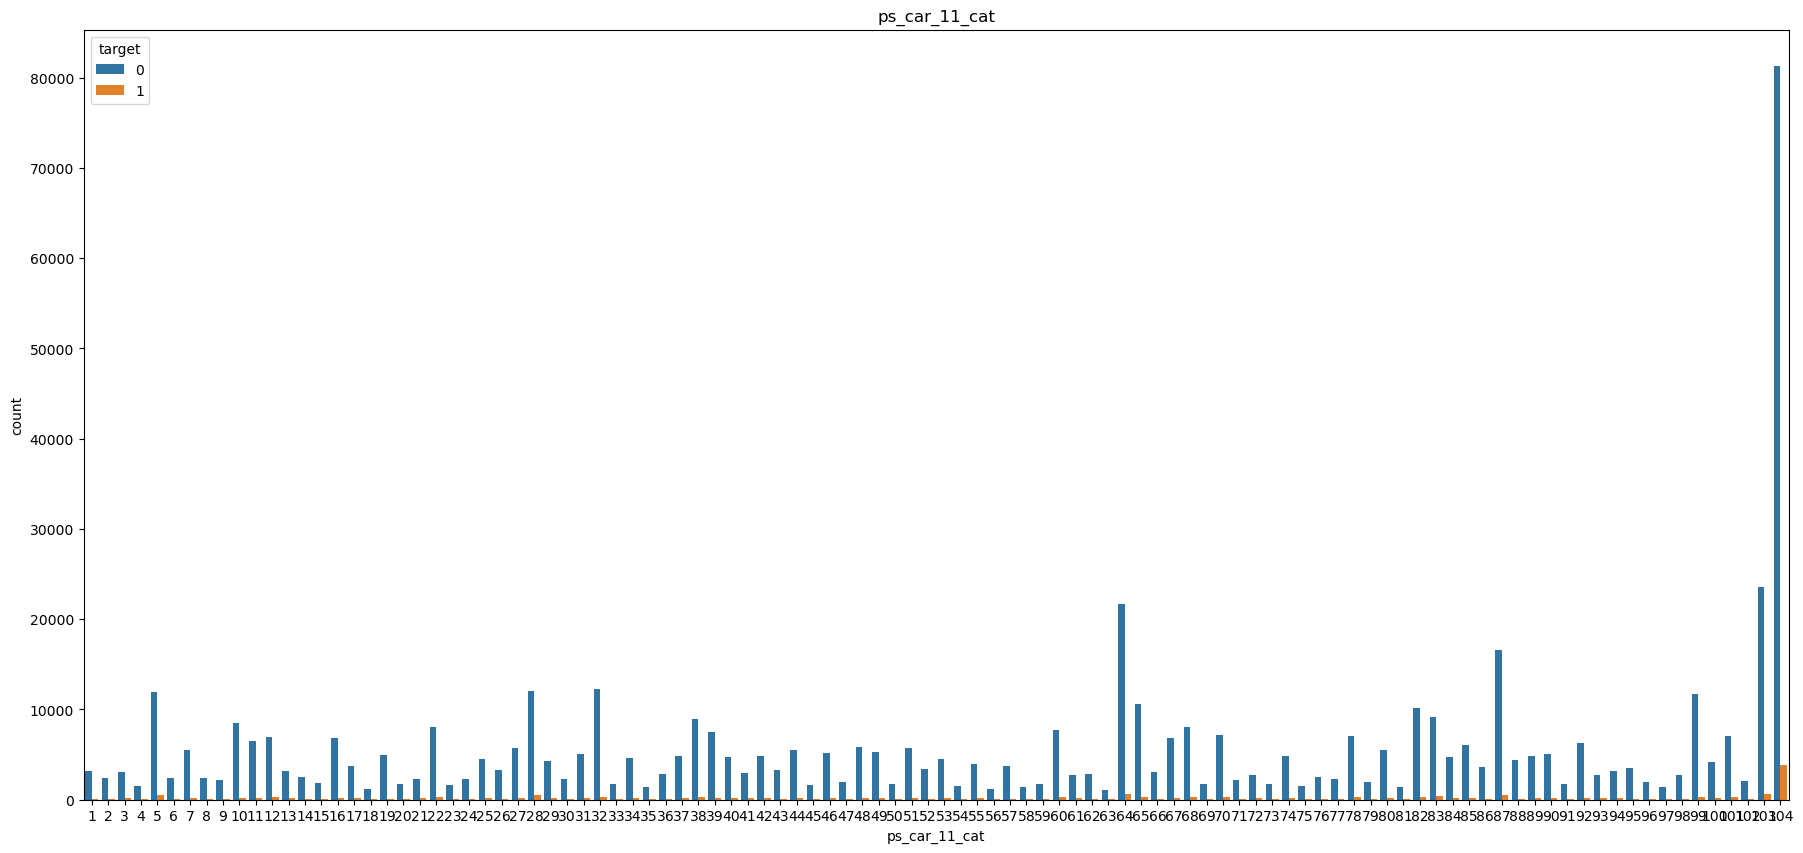

In [15]:
# Plotting count of each category for categorical features and using different colors for target 0 and 1

plt.figure(figsize = (15,22))
for i in range(len(cat_features)-1):
    plt.suptitle('Countplot of Categorical features for each class', fontsize = 'xx-large')
    plt.subplot(5,3,i+1)
    plt.title(cat_features[i])
    sns.countplot(x = train_df_cat[cat_features[i]], hue = train_df['target'])
    plt.tight_layout(pad=2)
plt.figure(figsize = (22,10))
plt.title(cat_features[-1])
sns.countplot(x = train_df_cat[cat_features[-1]], hue = train_df['target']);   # The feature ps_car_11_cat has many categories
                                                                              # which is not easy to visualize in a subplot
                                                                              # So, we are plotting it separately

In [16]:
print('Number of unique values of each categorical feature')
for i in range(len(cat_features)):
    print(cat_features[i], ' - ', len(train_df_cat[cat_features[i]].unique()))

Number of unique values of each categorical feature
ps_ind_02_cat  -  5
ps_ind_04_cat  -  3
ps_ind_05_cat  -  8
ps_car_01_cat  -  13
ps_car_02_cat  -  3
ps_car_03_cat  -  3
ps_car_04_cat  -  10
ps_car_05_cat  -  3
ps_car_06_cat  -  18
ps_car_07_cat  -  3
ps_car_08_cat  -  2
ps_car_09_cat  -  6
ps_car_10_cat  -  3
ps_car_11_cat  -  104


In [17]:
missing_val = (train_df_cat[train_df_cat==-1].sum()[lambda x:x!=0]) * -1
print('Number and Percentage of missing values in categorical features:')
for idx, val in enumerate(missing_val):
    print('{}  {}\t ({}%) '.format(missing_val.index[idx] , val , np.round(((val/len(train_df_cat))*100),3)))

Number and Percentage of missing values in categorical features:
ps_ind_02_cat  216.0	 (0.036%) 
ps_ind_04_cat  83.0	 (0.014%) 
ps_ind_05_cat  5809.0	 (0.976%) 
ps_car_01_cat  107.0	 (0.018%) 
ps_car_02_cat  5.0	 (0.001%) 
ps_car_03_cat  411231.0	 (69.09%) 
ps_car_05_cat  266551.0	 (44.783%) 
ps_car_07_cat  11489.0	 (1.93%) 
ps_car_09_cat  569.0	 (0.096%) 


## Observations:
1. Features ps_ind_05_cat, ps_car_04_cat, ps_car_07_cat, ps_car_10_cat all have the same category for nearly all the datapoints
2. None of the categorical features have a clear relationship in determining if insurance will be claimed or not.
3. ps_car_01_cat, ps_car_04_cat, ps_car_06_cat, ps_car_11_cat  have high number of categories. If we use one hot encoding, it will require many features. We can use response/target encoding for them and see if we get better performance.
4. Some features have missing values for which we can impute values based on the percentage of missing values in that feature. <Br>
   a) ps_ind_02_cat, ps_ind_04_cat, ps_ind_05_cat, ps_car_01_cat, ps_car_02_cat, ps_car_07_cat, ps_car_09_cat have very low number of missing values, so we can simply use the mode value <Br>
   b) ps_car_03_cat and ps_car_05_cat have high number of missing values, so we can leave the values as it is. <Br>


## EDA of Continuous features

In [18]:
# Getting all columns with column names that do not contain the string "bin" and "cat"
other_features = [col for col in train_df.columns if "bin" not in col and "cat" not in col]
del other_features[:2]   # Removing id and target features
train_df_other = train_df[other_features] 

In [19]:
print(len(other_features))
print(other_features)

26
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']


It is difficult to visualize all 26 univariate plots at the same time and analyze them. <Br>
There are 14 calc features and 12 features that are non-calc.  <Br>
We can group the calc features separately, perform EDA on them and also group the non-calc features and perform EDA on them.

In [20]:
# Separating calc and non-calc features
other_features_calc = [col for col in train_df_other.columns if "calc" in col]   
train_df_other_calc = train_df_other[other_features_calc]
other_features_not_calc = [col for col in train_df_other.columns if "calc" not in col]
train_df_other_not_calc = train_df_other[other_features_not_calc]

## EDA of Calc Features

### Probability Density Function of Calc Features

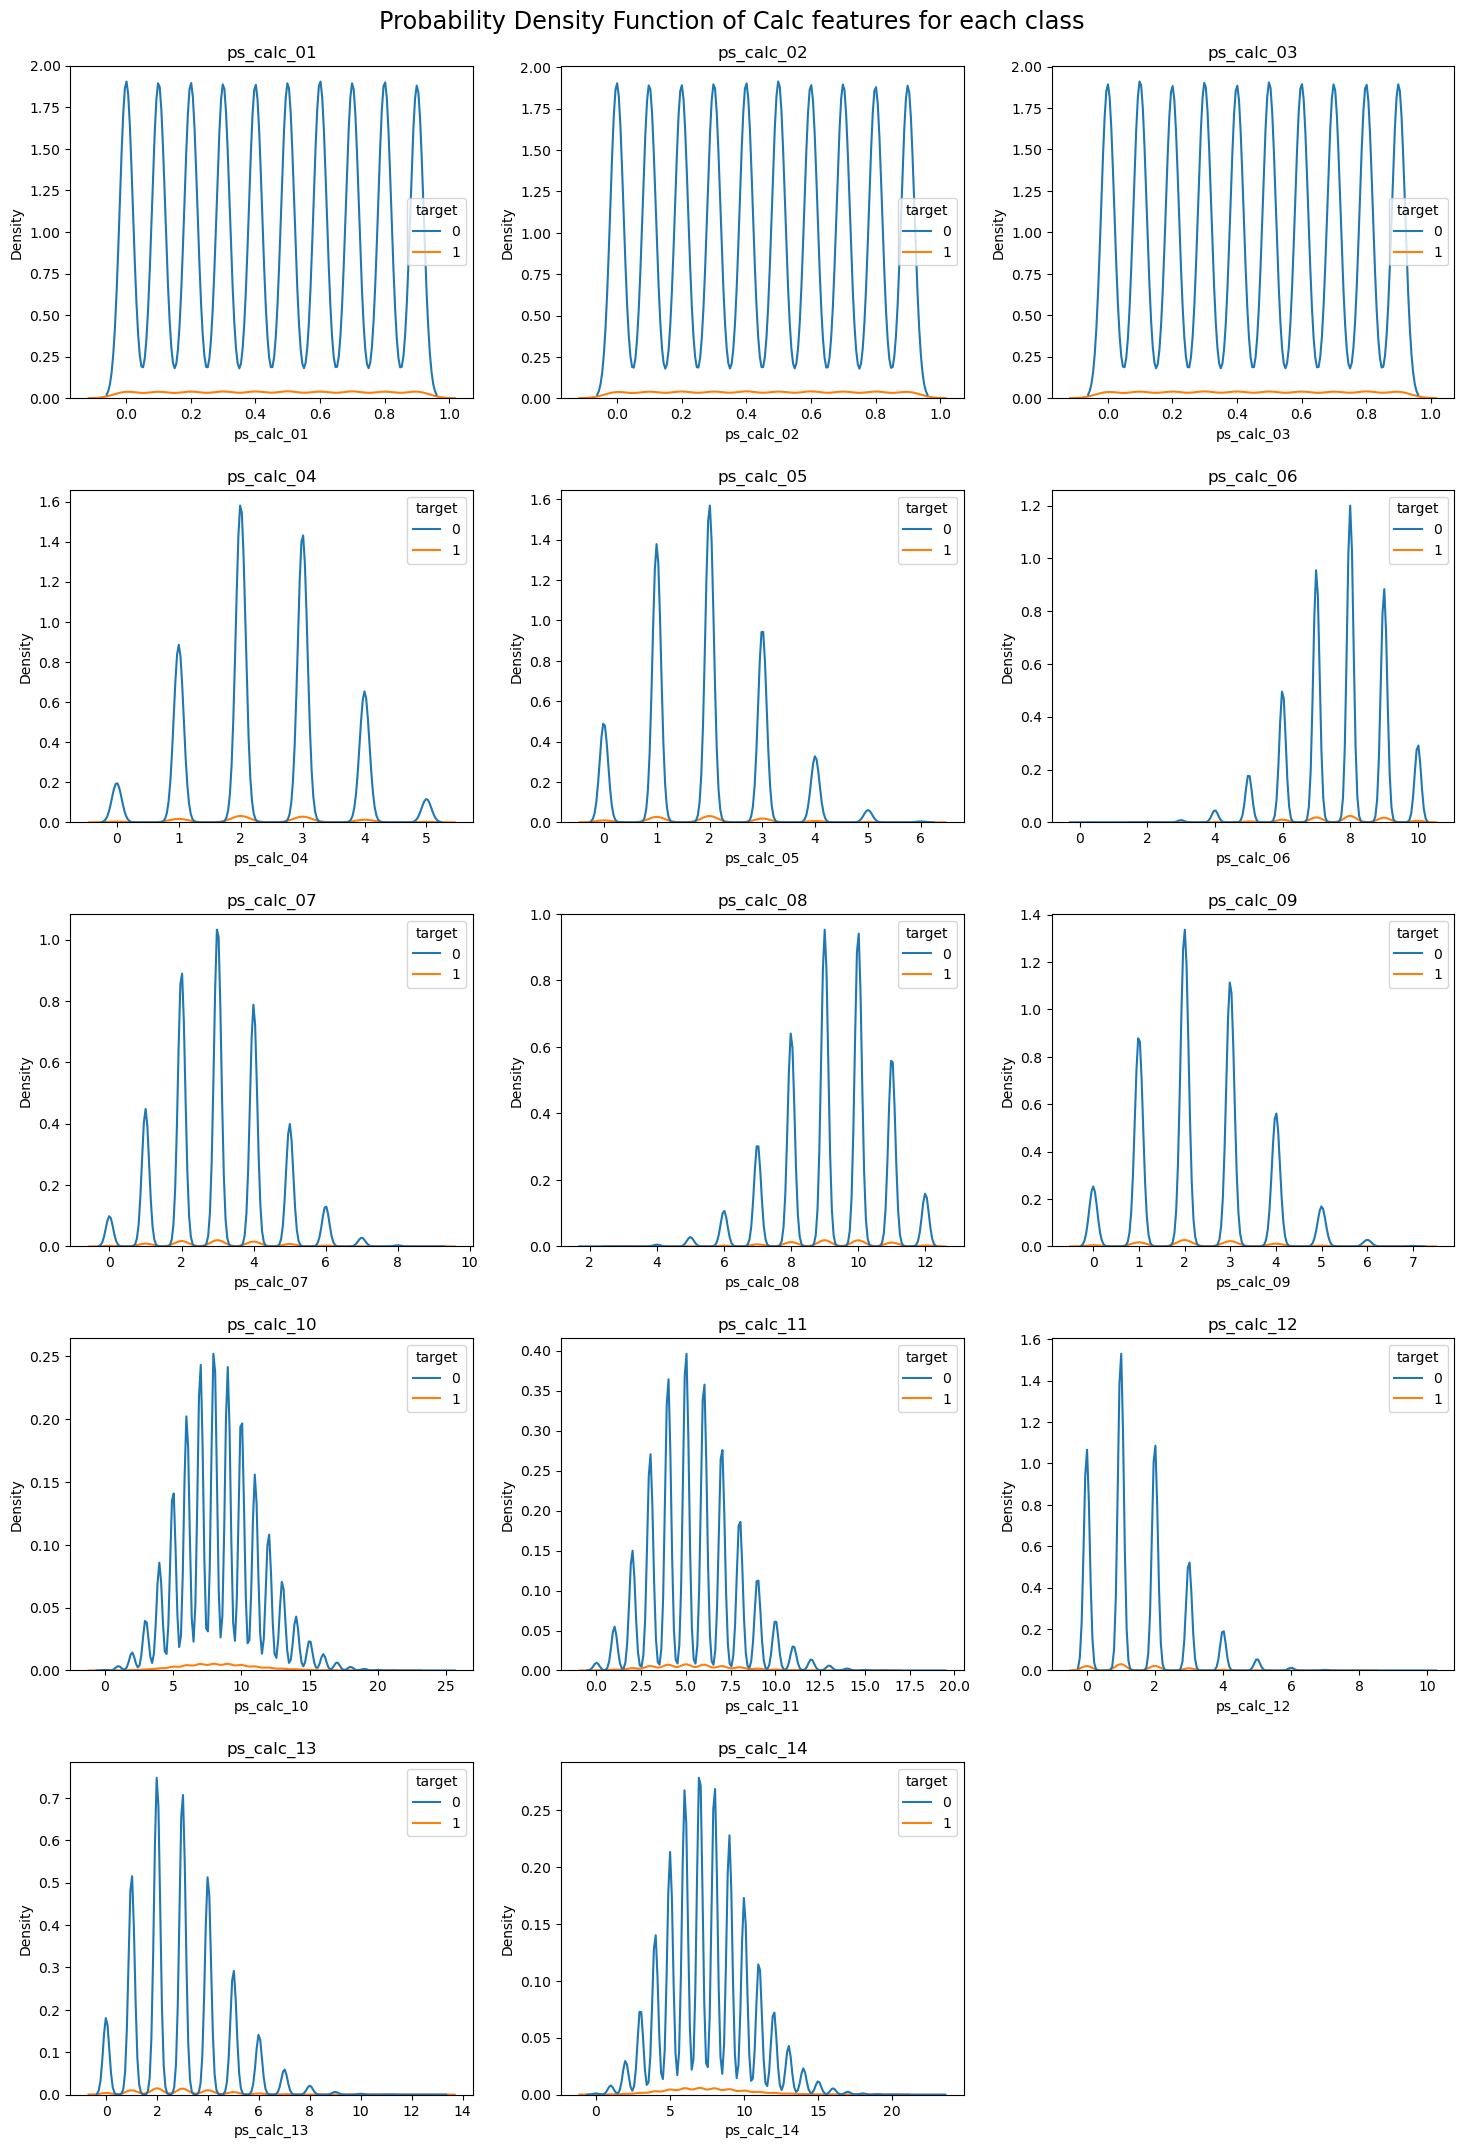

In [21]:
plt.figure(figsize = (15,22))
for i in range(len(other_features_calc)):
    plt.subplot(5,3,i+1)
    plt.suptitle('Probability Density Function of Calc features for each class', fontsize = 'xx-large')
    plt.title(other_features_calc[i])
    plot = sns.kdeplot(x = train_df_other_calc[other_features_calc[i]], hue = train_df['target'])
    plt.tight_layout(pad=2)

In [22]:
missing_val = (train_df_other_calc[train_df_other_calc==-1].sum()[lambda x:x!=0]) * -1
print('Number and Percentage of missing values in continuous non-calc features:')
for idx, val in enumerate(missing_val):
    print('{}  {}  \t ({}%) '.format(missing_val.index[idx] , val , np.round(((val/len(train_df_other_calc))*100),3)))

Number and Percentage of missing values in continuous non-calc features:


### Observations:
1. Features ps_calc_01, ps_calc_02, ps_calc_03 have uniform distribution.
2. Features ps_calc_10, ps_calc_11, ps_calc_14 seem to have gaussian distribution.
3. There are no missing values in calc features.

### Boxplot of Calc Features

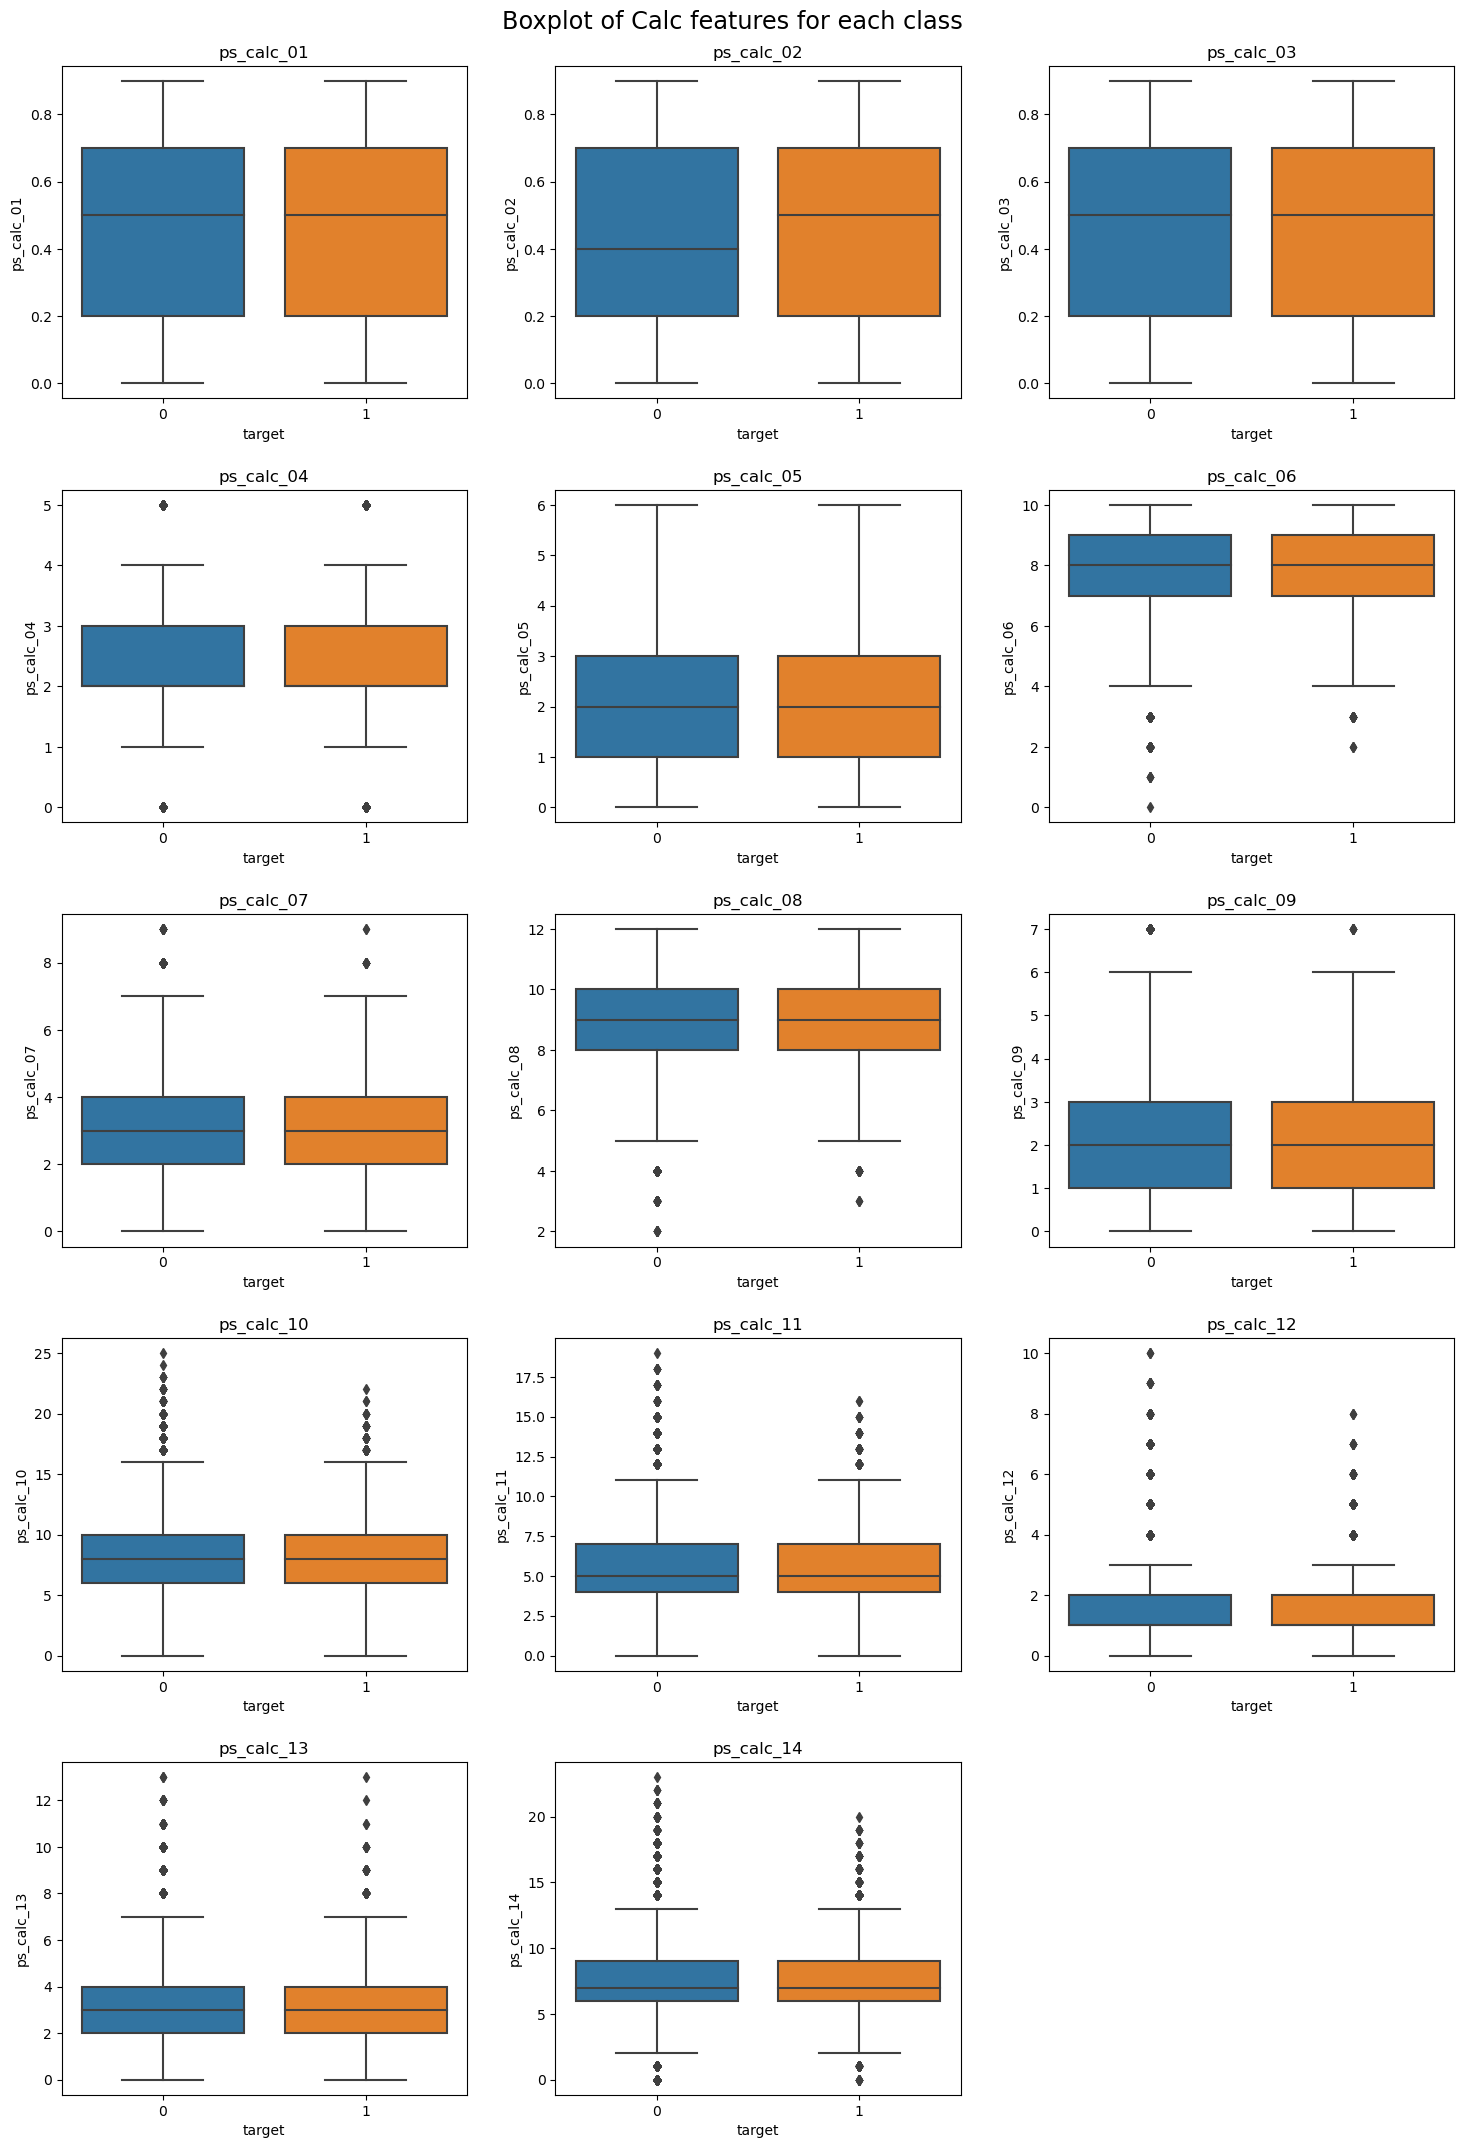

In [23]:
plt.figure(figsize = (15,22))
for i in range(len(other_features_calc)):
    plt.suptitle('Boxplot of Calc features for each class', fontsize = 'xx-large')
    plt.subplot(5,3,i+1)
    plt.title(other_features_calc[i])
    sns.boxplot(x = train_df['target'], y = train_df_other_calc[other_features_calc[i]])
    plt.tight_layout(pad=2.0)

### Observations:
1. There is no change in class distrubution in all calc features other than ps_calc_02.
2. Feature ps_calc_02 only has change in the mean between the two classes. Otherwise, it has the same distribution between the two classes.
3. Since there is no useful information in classifying the classes among the 'calc' features, it is better to not use these features.

### Checking for correlation between calc features

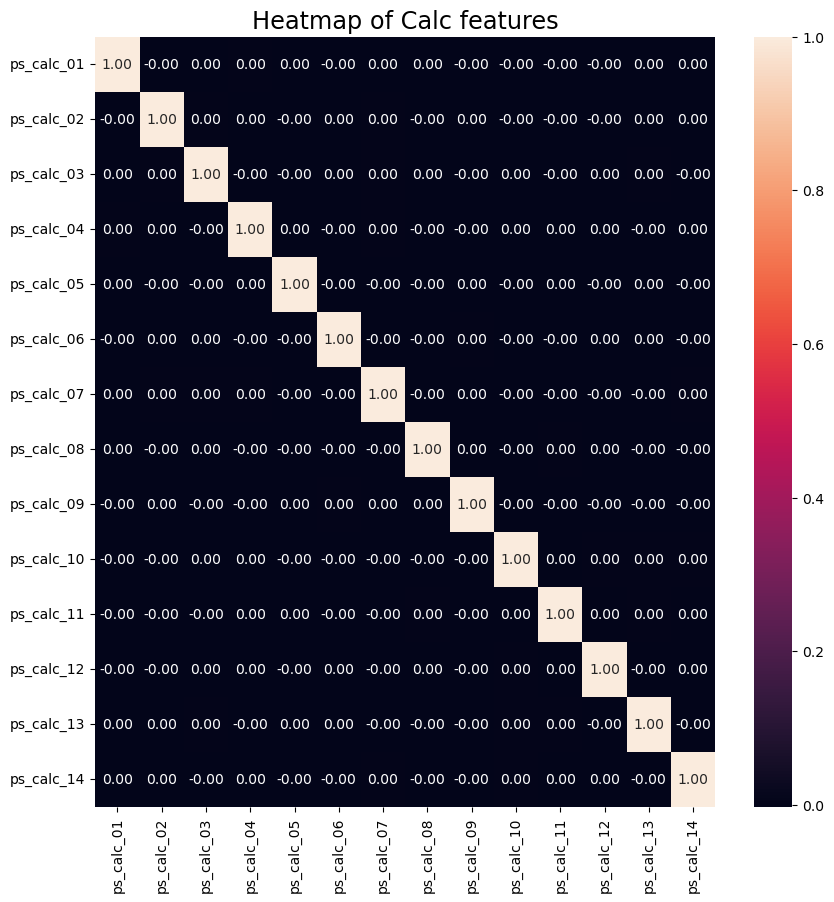

In [24]:
plt.figure(figsize=(10,10))
plt.title('Heatmap of Calc features', fontsize = 'xx-large')
sns.heatmap(train_df_other_calc.corr(),annot = True, fmt ='.2f');

### Observations:
1. There is no linear correlation between the calc features.

## EDA of Non-Calc Features

### PDF of Non-Calc Features

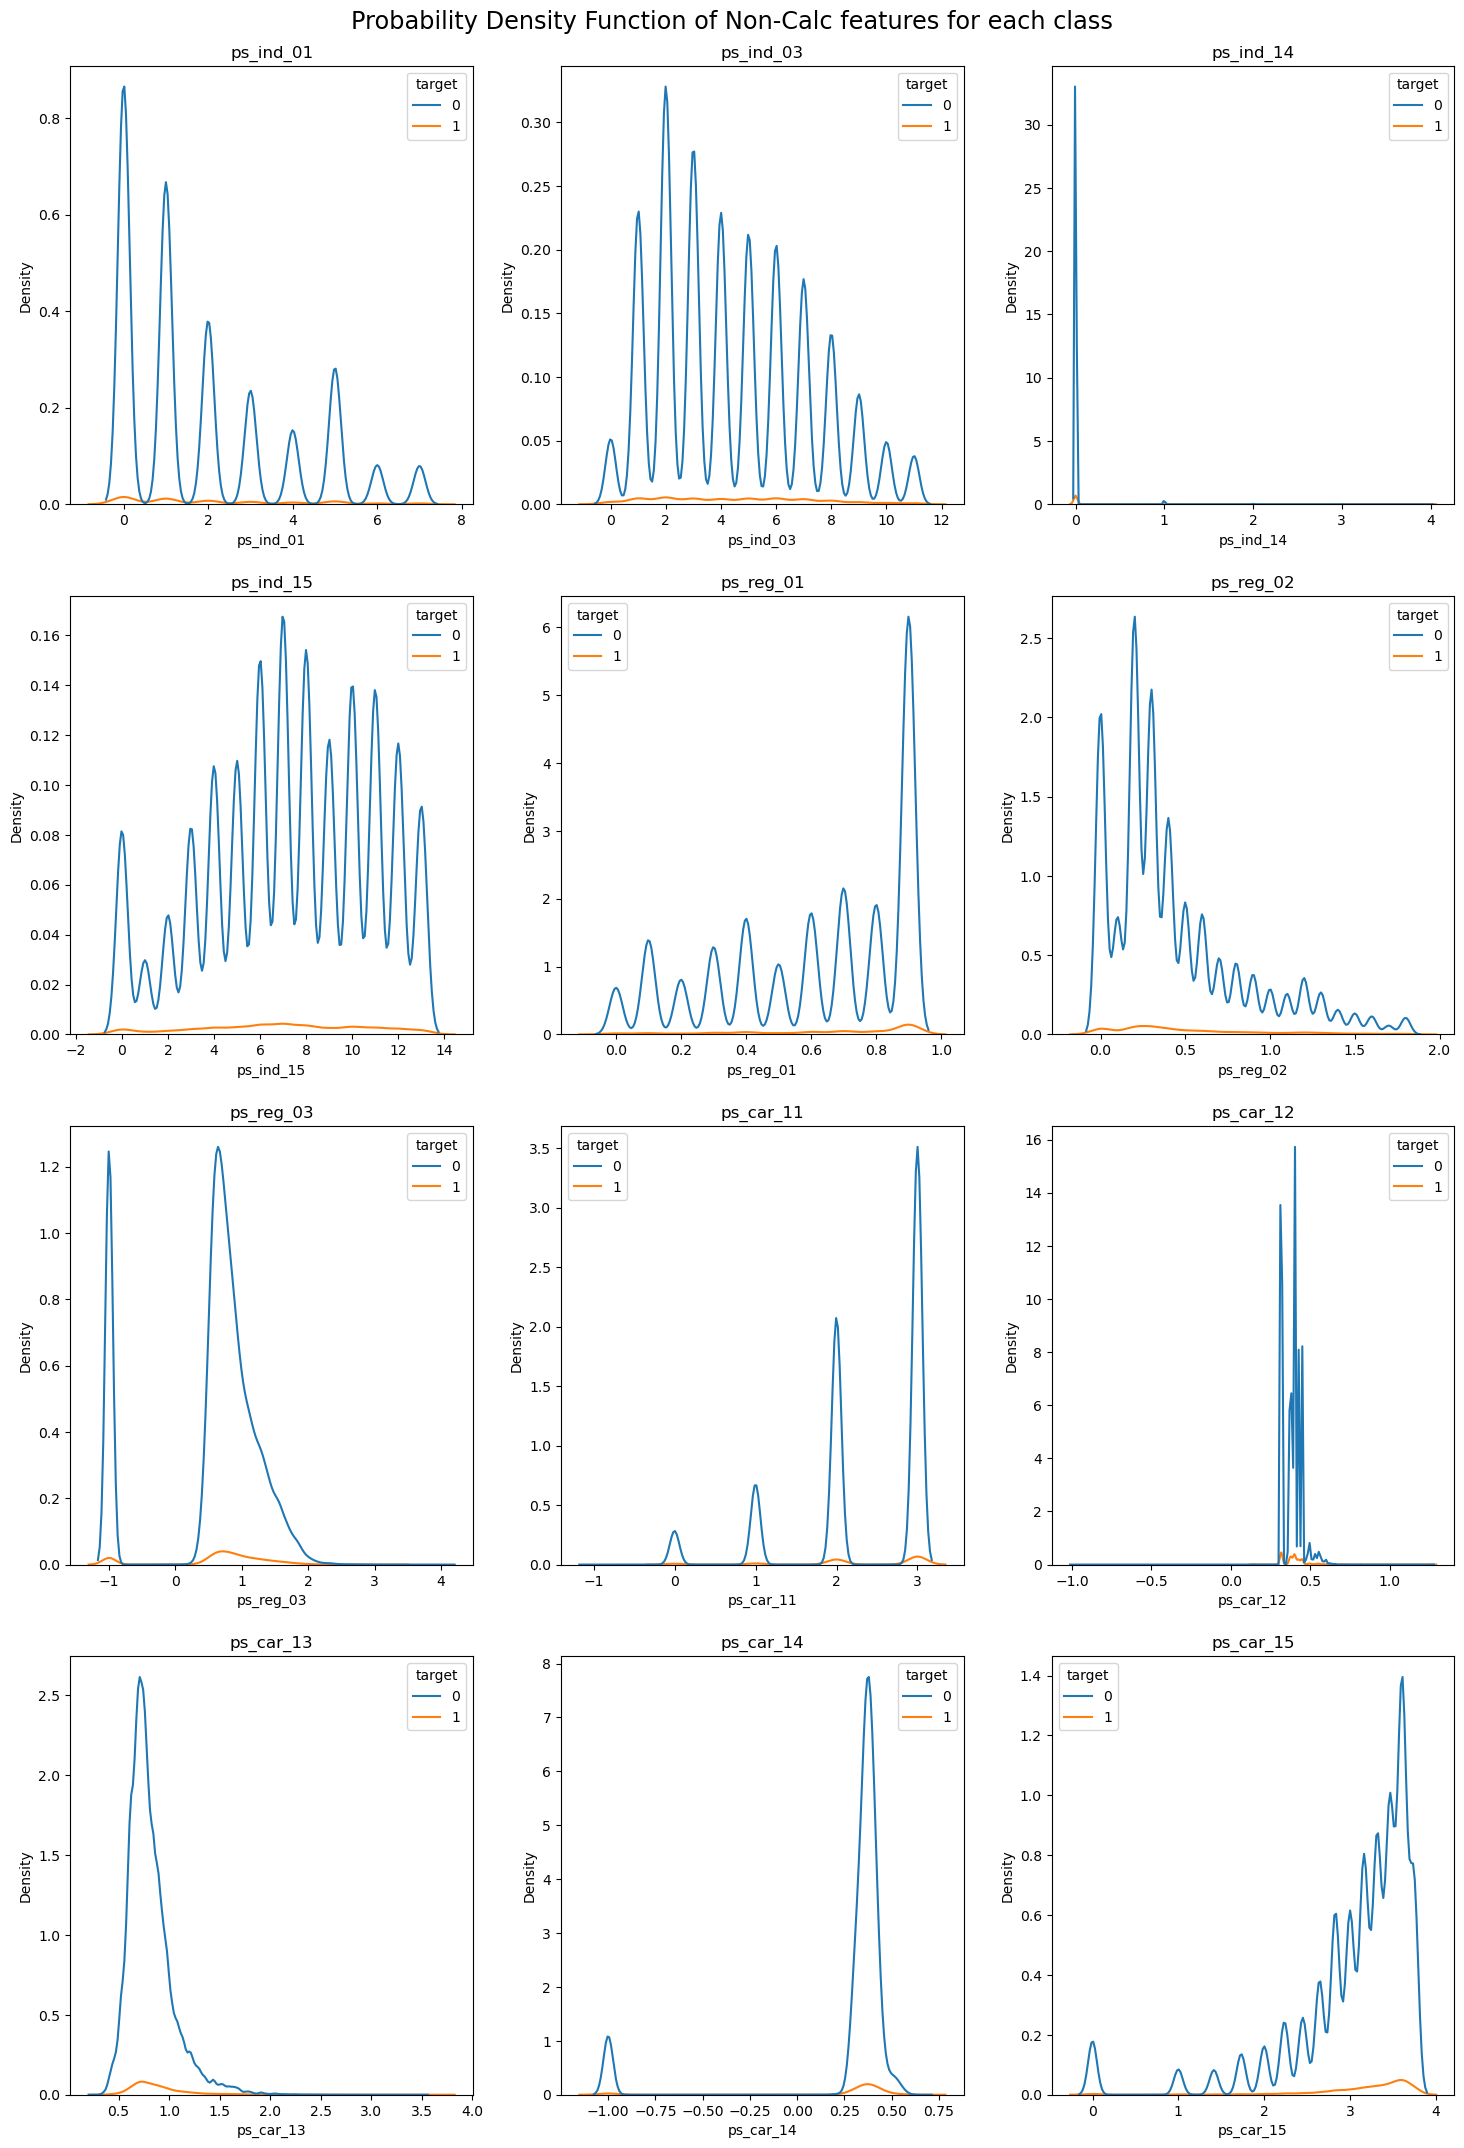

In [25]:
plt.figure(figsize = (15,22))
for i in range(len(other_features_not_calc)):
    plt.suptitle('Probability Density Function of Non-Calc features for each class', fontsize = 'xx-large')
    plt.subplot(4,3,i+1)
    plt.title(other_features_not_calc[i])
    sns.kdeplot(x = train_df_other_not_calc[other_features_not_calc[i]],  hue = train_df['target'])
    plt.tight_layout(pad=2.0)

In [26]:
missing_val = (train_df_other_not_calc[train_df_other_not_calc==-1].sum()[lambda x:x!=0]) * -1
print('Number and Percentage of missing values in continuous Non-calc features:')
for idx, val in enumerate(missing_val):
    print('{}  {}  \t ({}%) '.format(missing_val.index[idx] , val , np.round(((val/len(train_df_other_not_calc))*100),3)))

Number and Percentage of missing values in continuous Non-calc features:
ps_reg_03  107772.0  	 (18.106%) 
ps_car_11  5.0  	 (0.001%) 
ps_car_12  1.0  	 (0.0%) 
ps_car_14  42620.0  	 (7.16%) 


### Observations:
1. Features ps_ind_14, ps_car_13, ps_car_14, ps_car_12 have most of its values within a short range (very high density at certain points).
2. Some features have missing values for which we can impute values based on the percentage of missing values in that feature.<Br>  a) ps_car_11 , ps_car_12 , ps_car_14 have less than 10% of total data as missing values. So, we can use mean for the missing values. <Br>
    b) ps_reg_03 has more that 10% of data as missing values. We can leave it as it is. <Br>

### Boxplot of Non-Calc Features

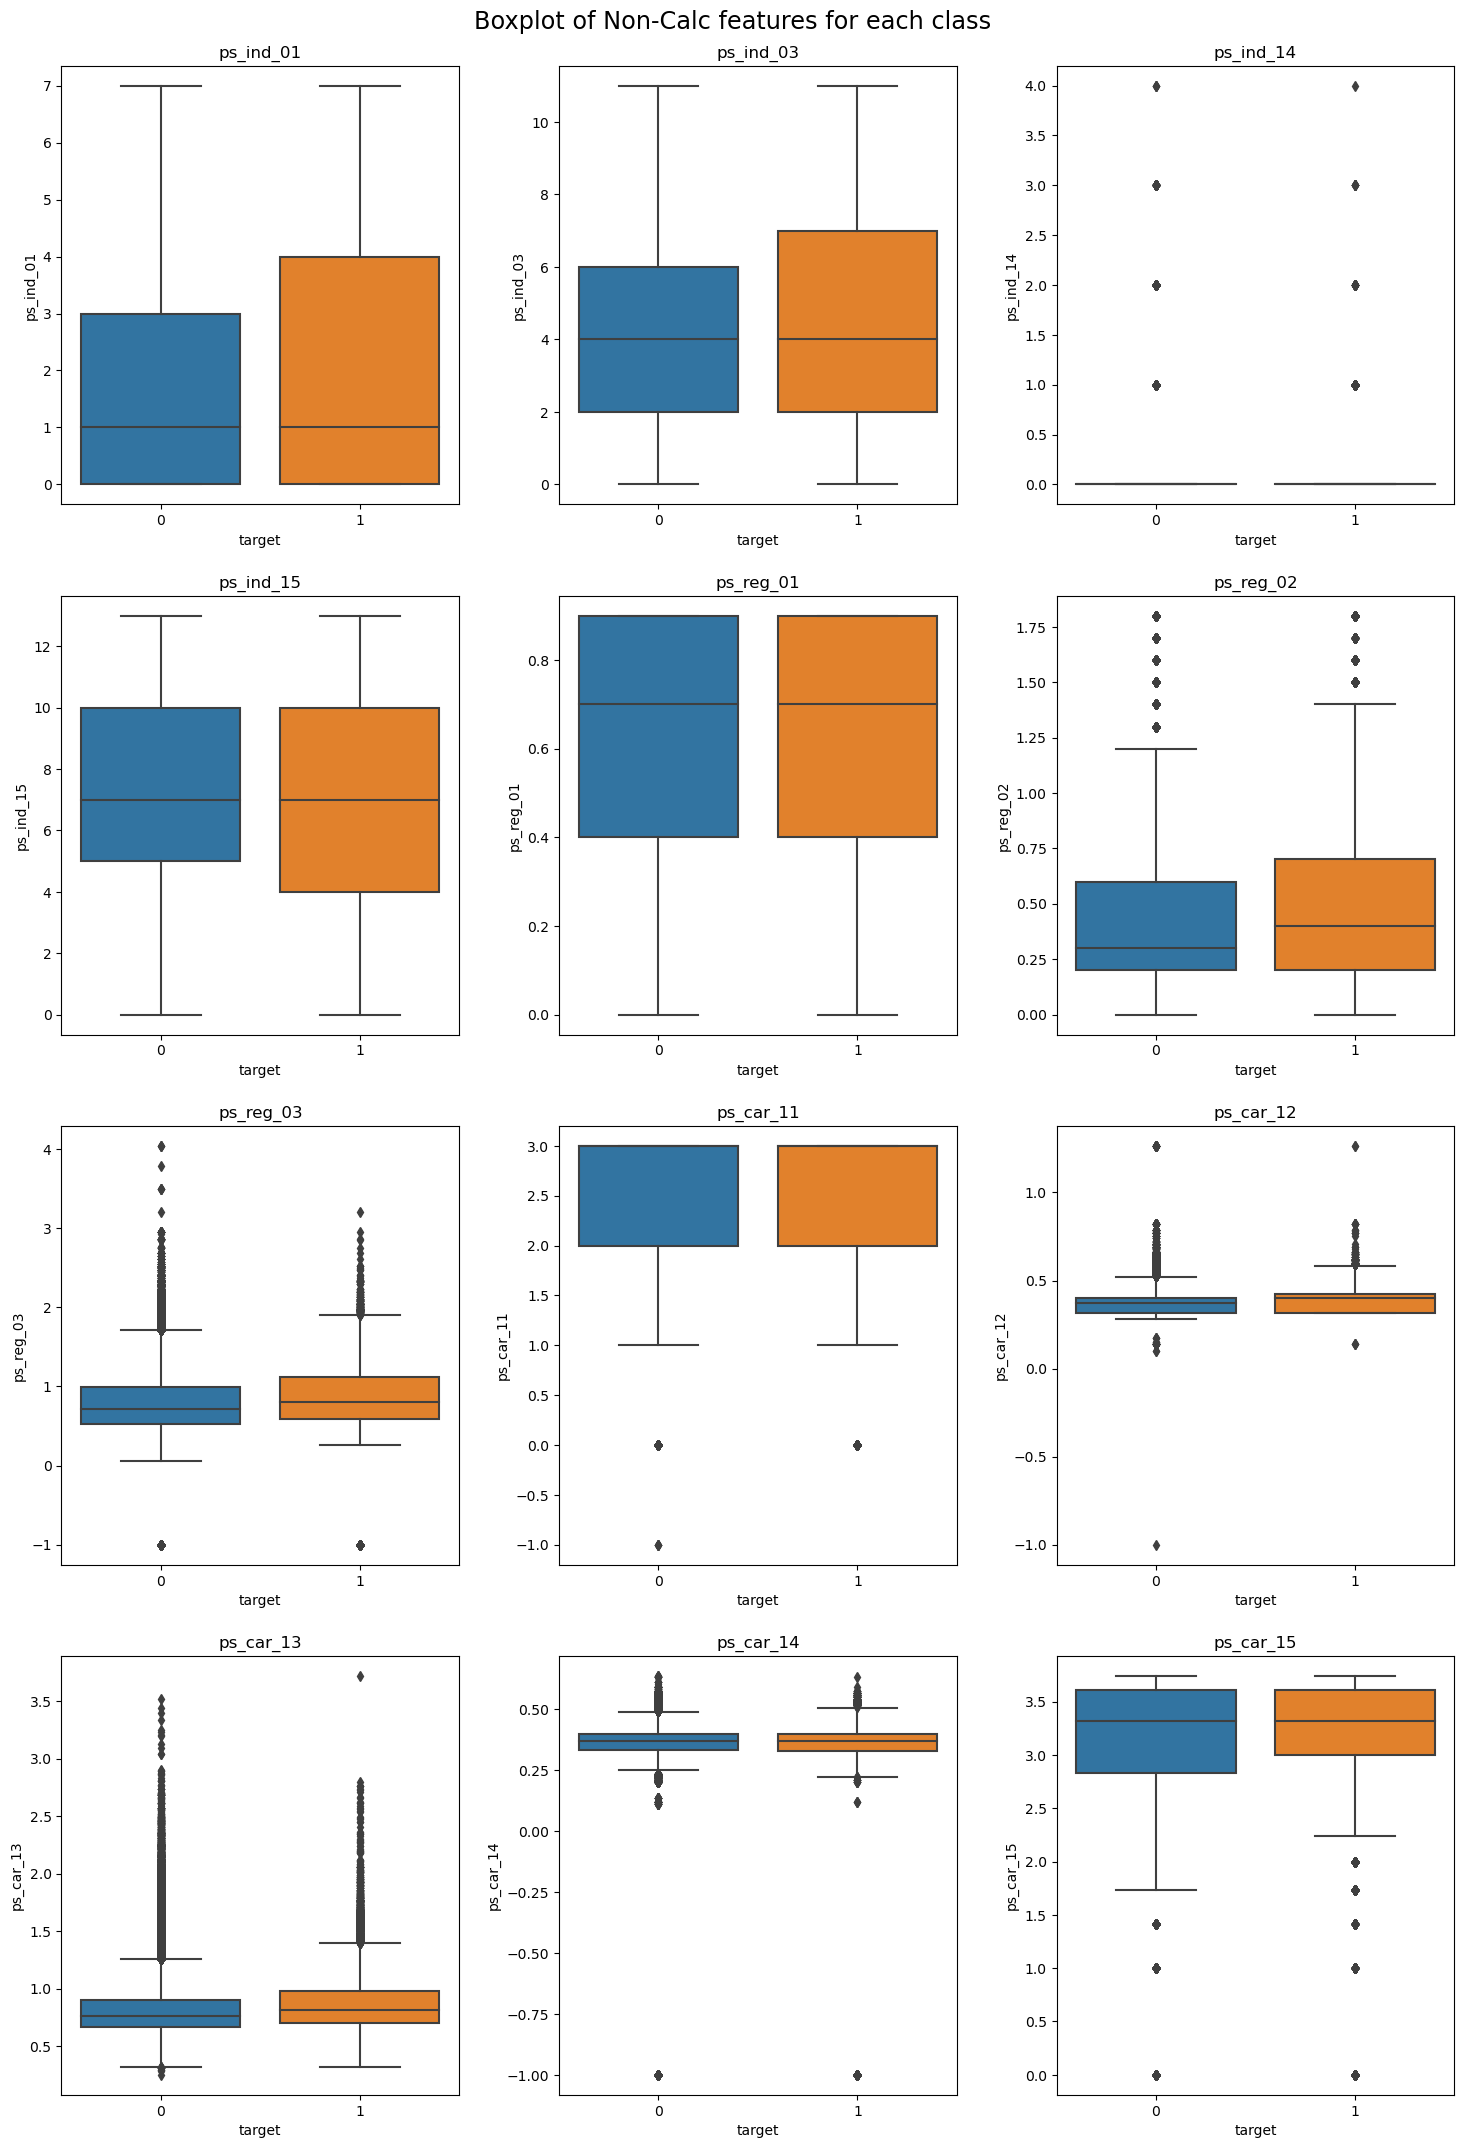

In [27]:
plt.figure(figsize = (15,22))
for i in range(len(other_features_not_calc)):
    plt.suptitle('Boxplot of Non-Calc features for each class', fontsize = 'xx-large')
    plt.subplot(4,3,i+1)
    plt.title(other_features_not_calc[i])
    sns.boxplot(x = train_df['target'], y = train_df_other_not_calc[other_features_not_calc[i]])
    plt.tight_layout(pad=2.0)

### Observations:
1. Feature ps_ind_14 is an ordinal feature where nearly all the datapoints have value 0. 
2. Features ps_ind_01, ps_ind_03, ps_ind_15, ps_reg_02 show some difference in distribution between the two classes.

### Checking for correlation between non-calc continuous features

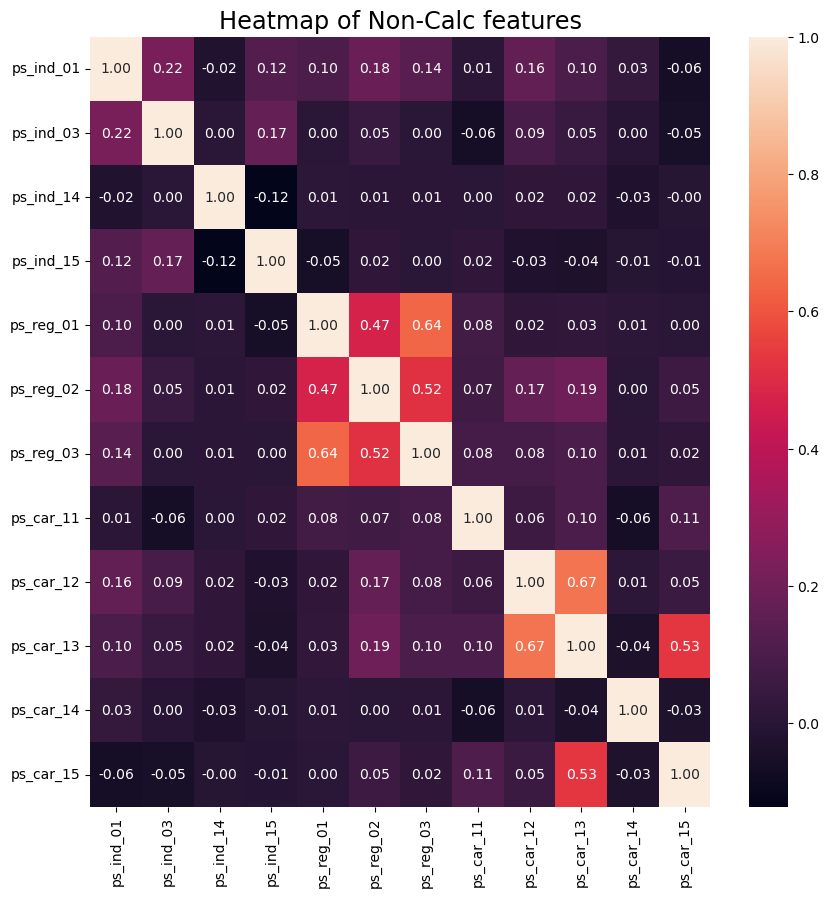

In [28]:
plt.figure(figsize=(10,10))
plt.title('Heatmap of Non-Calc features', fontsize = 'xx-large')
sns.heatmap(train_df_other_not_calc.corr(),annot = True, fmt ='.2f');

### Observations:
1. The following features have moderately positive linear correlation coefficient values <Br>
    a) ps_car_12 and ps_car_13 &nbsp;&nbsp; (0.67)<Br>
    b) ps_reg_01 and ps_reg_03 &nbsp;&nbsp; (0.64)<Br>
    c) ps_car_13 and  ps_car_15 &nbsp;&nbsp; (0.53)<Br>
    d) ps_reg_02 and ps_reg_03 &nbsp;&nbsp; (0.52)<Br>

Let's visualize these 4 pairs of features and see if they have high correlation

In [29]:
correlated_features = [['ps_car_13', 'ps_car_12'], ['ps_reg_01', 'ps_reg_03'], ['ps_car_13', 'ps_car_15'], 
                       ['ps_reg_02', 'ps_reg_03']]

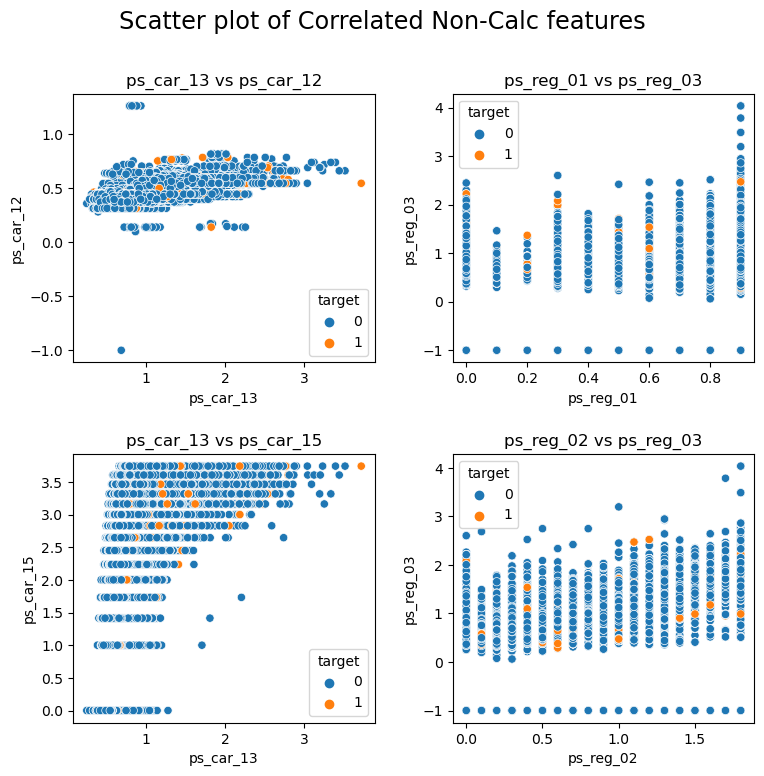

In [30]:
plt.figure(figsize = (8,8))
for i in range(len(correlated_features)):
    plt.suptitle('Scatter plot of Correlated Non-Calc features', fontsize = 'xx-large')
    plt.subplot(2,2,i+1)
    plt.title(str(correlated_features[i][0]) + ' vs ' + str(correlated_features[i][1]))
    sns.scatterplot(data = train_df, x =correlated_features[i][0],  y = correlated_features[i][1], hue = 'target')
    plt.tight_layout(pad=2.0)

### Observations:
1. ps_car_12 and ps_car_13 show a moderate amount of linear correlation but not high enough to be of great concern.
2. The other 3 pair of features do not exhibit much linear correlation.